# Test / retest reliability of classifications

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join as opj
from matplotlib import pyplot as plt
import scipy
from polyML import bootstrap_tools as bt
from polyML import TON_tools3 as TON_tools
%matplotlib inline

sns.set_style('darkgrid')

## Load data

In [2]:
results_dir = '/data1/chdi_results/polo/polyML/results/degree/bct/thres07/non_smooth/cross-site-CV/age-sex-corrected'
results_csv =  'SAGA_log_elastic_predictions.csv'

results_fn = opj(results_dir, results_csv)
results_df = pd.read_csv(results_fn)

out_dir = '/data2/polo/figures'
do_save = True

### Preprocess
Make a column with TP, TN, FP, FN

In [3]:
TF_dict = {True: 'T', False: 'F'}
PN_dict = {True: 'P', False: 'N'}

TF_input = results_df['labels'] == results_df['prediction']
PN_input = results_df['prediction'] == 1

results_df['TPNF'] = np.array([TF_dict[TF_input[i]] + PN_dict[PN_input[i]] for i in range(TF_input.shape[0])])

init = results_df['TPNF'].iloc[::2].values
final = results_df['TPNF'].iloc[1::2].values
init_final = np.vstack([init, final]).T

Design a transition matrix

In [4]:
T=bt.transition_matrix_from_2D_array(init_final)


In [5]:
n_randomizations = 1e5 #5e4 #1e2 #

T_dist = bt.make_transition_dist(init_final, int(n_randomizations),
                                 shuffle=True, replacement=False)

In [6]:
# Mean random transition matrix
T_dist.mean(axis=2)

array([[ 0.60735673,  0.39264327,  0.        ,  0.        ],
       [ 0.607984  ,  0.392016  ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.3242725 ,  0.6757275 ],
       [ 0.        ,  0.        ,  0.32436381,  0.67563619]])

In [7]:
# Mean transition matrix
T

array([[ 0.75510204,  0.24489796,  0.        ,  0.        ],
       [ 0.36666667,  0.63333333,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.6875    ,  0.3125    ],
       [ 0.        ,  0.        ,  0.04761905,  0.95238095]])

In [8]:
#Compute p-values
K = np.reshape(T, (4, 4, 1))
T0 = np.tile(K, (1, 1, T_dist.shape[2]))

#p_val for diagonal terms
print('P-val for diagonal terms:')
print(((T_dist-T0)>=0).sum(axis=2)/T_dist.shape[2])

#p-val for off-diagonal terms
print('P-val for off-diagonal terms:')
print(((T_dist-T0)<=0).sum(axis=2)/T_dist.shape[2])

P-val for diagonal terms:
[[  6.90000000e-04   9.99910000e-01   1.00000000e+00   1.00000000e+00]
 [  9.99910000e-01   6.90000000e-04   1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00   0.00000000e+00]]
P-val for off-diagonal terms:
[[  9.99910000e-01   6.90000000e-04   1.00000000e+00   1.00000000e+00]
 [  6.90000000e-04   9.99910000e-01   1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00]]


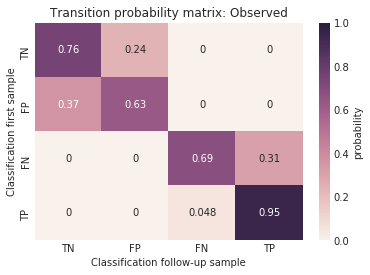

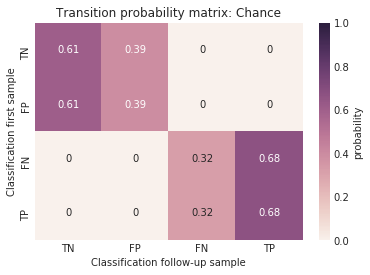

In [12]:
key_ids = ['TN', 'FP', 'FN', 'TP']
p_mats = [pd.DataFrame(T,columns=key_ids, index=key_ids),
          pd.DataFrame(T_dist.mean(axis=2),columns=key_ids, index=key_ids)]
cbar_vals=[True, True]
subtitle = ['Observed', 'Chance']
#f, axes = plt.subplots(1, 2, sharey=True)
#fh = plt.figure()
formats_used = ['png', 'pdf']
for m_ix, mm in enumerate(p_mats):
    #plt.sca(axes[m_ix])
    fh = plt.figure()
    #sns.heatmap(mm, vmin=0, vmax=1, annot=True, ax=axes[m_ix], cbar=cbar_vals[m_ix])
#     ax = sns.heatmap(mm[['FN', 'TP']].loc[['FN', 'TP']], vmin=0, vmax=1, annot=True, cbar=cbar_vals[m_ix],
#                     cbar_kws={'label': 'probability'})#, ax=axes[m_ix])
    ax = sns.heatmap(mm, vmin=0, vmax=1, annot=True, cbar=cbar_vals[m_ix],
                     cmap=sns.cubehelix_palette(light=.95, as_cmap=True),
                    cbar_kws={'label': 'probability'})#, ax=axes[m_ix])
    #axes[m_ix].set_aspect(1)
    ax.set_ylabel('Classification first sample')
    ax.set_xlabel('Classification follow-up sample')
    ax.set_title('Transition probability matrix: {}'.format(subtitle[m_ix]))
    if do_save:
        for fmt in formats_used:
            fh.savefig(opj(out_dir, 'consistency_transitions_{}.{}'.format(subtitle[m_ix],fmt)),dpi=300)

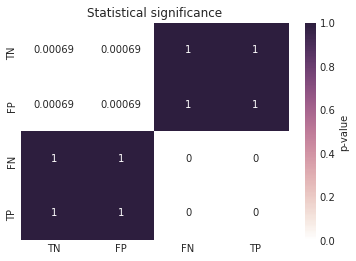

In [10]:
pmat = ((T_dist-T0)<=0).sum(axis=2)/T_dist.shape[2]
np.fill_diagonal(pmat,(((T_dist-T0)>=0).sum(axis=2)/T_dist.shape[2]).diagonal())
pm_df = pd.DataFrame(pmat,columns=key_ids, index=key_ids)

fh = plt.figure()
ax = sns.heatmap(pm_df, vmin=0, vmax=1, annot=True, cbar=True,
                 cmapp=sns.cubehelix_palette(light=1, as_cmap=True),
                    cbar_kws={'label': 'p-value'},fmt='.2g')#, ax=axes[m_ix])
ax.set_title('Statistical significance')
if do_save:
    for fmt in formats_used:
        fh.savefig(opj(out_dir, 'consistency_transitions_pval.{}'.format(fmt)),dpi=300)